In [2]:
!pip install uq360

  Using cached uq360-0.2-py3-none-any.whl (172 kB)


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
try:
    from uq360.metrics import picp, mpiw, compute_regression_metrics
    from uq360.metrics import UncertaintyCharacteristicsCurve as ucc

    from uq360.algorithms import * 
    from uq360.algorithms.actively_learned_model import ActivelyLearnedModel
    from uq360.algorithms.ensemble_heteroscedastic_regression import EnsembleHeteroscedasticRegression

    import pandas as pd
    import numpy as np
    import torch

    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    print('All the libraries are found')
    
except:
    print("One or more libraries need to be installed")

All the libraries are found


In [24]:
def read_data(file_name,sheet_name):
    
    xls_new = pd.ExcelFile(file_name)
    df=pd.read_excel(xls_new,sheet_name,header=1).dropna(how='all', axis=1)
    df.drop('#',axis=1,inplace=True)
    
    return df

data = read_data(r'/data/MGP/TestPoints_100k_NEW.xlsx','ResFeasible')

In [25]:
def select_columns(df,columns,input_columns,output_columns):
    
    df = df[columns]
    df['Diff_Pressure'] = df['Pout [kPA]'] - df['Pin [kPa]']
    df = pd.concat([df[input_columns],df[output_columns]],axis=1)
    
    return df

In [26]:
columns = ['Tin [K]','Pin [kPa]','N [rpm]','Total Consumed power','Pout [kPA]','GVFin','Qin [m3/s]']
INPUT_C = ['Tin [K]','Pin [kPa]','N [rpm]','Total Consumed power','Pout [kPA]']
OUTPUT_C =['Qin [m3/s]']
data_1 = select_columns(data,columns,INPUT_C,OUTPUT_C)

/tmp/ipykernel_2404/4194695666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Diff_Pressure'] = df['Pout [kPA]'] - df['Pin [kPa]']


In [27]:
data_1.shape

(61225, 6)

In [8]:
# scale the data and select the number of samples to be considered
def scale_data(df,samples):
    df_1 = df[0:samples]
    df_x = df_1.iloc[:, :-1].values
    y_labels = np.squeeze(df_1.iloc[:, -1:].values, axis=1)
    y_labels = y_labels.reshape((-1,1))

    # scale the values
    scaler = StandardScaler()
    scaling = scaler.fit(df_x)
    x_data = scaling.transform(df_x)
    
    
    return df, y_labels, x_data

data,y_labels,x_data = scale_data(data_1,15000)

In [9]:
''' 
    Offline sample and query, two mandatory arguments (and the data):
    - Position where to start sampling
    - Number of points to sample
'''
def sample_(start_index, n_points, X_data=x_data):
    return x_data[start_index:start_index+n_points,:]

def querry_(start_index, n_points, y_labels=y_labels):
    return y_labels[start_index:start_index+n_points]


In [10]:
# define configuration for both models, regression baseline and regression with Active Learning
def config_():
    device = torch.device("cpu")

    # define config for Heteroscedastic regression
    config_HR = {"num_features": 5, "num_hidden": 32, "num_outputs": 1, "batch_size": 16, "num_epochs": 10,
                      "lr": 0.001}
    HR_kwargs = {"model_type":'mlp',
                   "config": config_HR,
                   "device": device}
    # define config for ensemble
    config_ensemble = {"num_models": 1, 
              "batch_size": 16,
              "model_kwargs":HR_kwargs, }

    ninit = 128
    T = 4 # do not change this, since the model is CPU based  T 25 gives error need atleast one array
    # define config for active learning object
    # T = # no of iterations
    # K = # no of uncertain points
    config_AL = {"num_init": 512, 
     "T": 4, 
     "K": 64, 
     "M": 4, 
     "sampling_function": sample_, 
     "querry_function" : querry_,
     "model_function": EnsembleHeteroscedasticRegression,
     "model_kwargs": {"model_type":'ensembleheteroscedasticregression', 
                                                 "config":config_ensemble, 
                                                 "device":device}, }
    
    return config_HR,HR_kwargs,config_AL
config_HR,HR_kwargs,config_AL = config_()

In [11]:
# Verify that the data set has the good dimension
def verify_dimension(data_x,config_AL,config_HR):
    
    assert(data_x.shape[0] >= config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"])
    assert(data_x.shape[1] == config_HR["num_features"])
    
    return True

verify_dimension(x_data,config_AL,config_HR)

True

In [12]:
def baseline(config_AL):
    # Baseline without AL
    K_train_list = [16, 32, 64, 128, 256, 512]
    frac_err_baseline = []
    ninit=128
    N_test = 512
    device = torch.device("cpu")
    T=4
    for i in range(len(K_train_list)):

        # Update dictiorary to have no active learning and the correct amount of points
        config_AL["model_kwargs"]["config"]["num_models"] = 5
        config_AL["num_init"] = ninit + K_train_list[i] * T
        print(config_AL["num_init"])
        config_AL["T"] = 0  # no AL here

        # Instantiate the class object and train the model
        uq_model = ActivelyLearnedModel(config=config_AL, device=device, online=False)
        uq_model = uq_model.fit() # until here it is working # model loss -training

        # Create a test dataset
        X_test = sample_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = querry_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = np.reshape(y_test, (-1,))
        print(X_test.shape,y_test.shape)

        res = uq_model.predict(X_test) 
        print(X_test.shape)
        y_test_pred = np.squeeze(res.y_mean, axis=1)

        frac_err_baseline.append(np.sqrt(np.sum(np.square(y_test - y_test_pred)))/np.sqrt(np.sum(np.square(y_test))))
        print('iteration---------',i)
        
    return  frac_err_baseline

In [13]:
errors_baseline=baseline(config_AL)

192

Training model 0

Epoch: 0, loss = 0.6796340694030125
Epoch: 1, loss = 0.5946309665838877
Epoch: 2, loss = 0.5205294887224833
Epoch: 3, loss = 0.44867390890916187
Epoch: 4, loss = 0.3744939242800077
Epoch: 5, loss = 0.29527637362480164
Epoch: 6, loss = 0.20841552565495172
Epoch: 7, loss = 0.1126761371269822
Epoch: 8, loss = 0.007132950394103926
Epoch: 9, loss = -0.10853254670898121

Training model 1

Epoch: 0, loss = 0.7060784995555878
Epoch: 1, loss = 0.6407881478468578
Epoch: 2, loss = 0.5770089874664942
Epoch: 3, loss = 0.5110952133933704
Epoch: 4, loss = 0.4401779994368553
Epoch: 5, loss = 0.36200803766647977
Epoch: 6, loss = 0.27497686569889385
Epoch: 7, loss = 0.17763172214229903
Epoch: 8, loss = 0.06857905102272828
Epoch: 9, loss = -0.05339208866159121

Training model 2

Epoch: 0, loss = 0.7263005077838899
Epoch: 1, loss = 0.6316579778989156
Epoch: 2, loss = 0.5539224793513615
Epoch: 3, loss = 0.48027773946523655
Epoch: 4, loss = 0.40363502502441406
Epoch: 5, loss = 0.32259

Epoch: 0, loss = 0.5815719999372962
Epoch: 1, loss = 0.04876079453000179
Epoch: 2, loss = -0.7841748251683185
Epoch: 3, loss = -1.3669896870851517
Epoch: 4, loss = -1.589398004942471
Epoch: 5, loss = -1.7097006489833195
Epoch: 6, loss = -1.8377373384104838
Epoch: 7, loss = -1.868712196747462
Epoch: 8, loss = -1.9592508706781602
Epoch: 9, loss = -1.9930766042735844

Training model 2

Epoch: 0, loss = 0.6772785439259478
Epoch: 1, loss = 0.2230586311003815
Epoch: 2, loss = -0.5181641405862236
Epoch: 3, loss = -1.0138409435749056
Epoch: 4, loss = -1.409897049268087
Epoch: 5, loss = -1.5279261594017346
Epoch: 6, loss = -1.7107144378953505
Epoch: 7, loss = -1.7110348037547538
Epoch: 8, loss = -1.8581967237922883
Epoch: 9, loss = -1.9273653974135716

Training model 3

Epoch: 0, loss = 0.5687730602092214
Epoch: 1, loss = 0.08176980880347802
Epoch: 2, loss = -0.4691851449509462
Epoch: 3, loss = -1.0108777301179037
Epoch: 4, loss = -1.369976685278946
Epoch: 5, loss = -1.6273830516470806
Epoch: 6

In [15]:
def with_al(config_AL):
    # AL, ensemble of 5 NNs
    frac_err_AL_ens = []
    device = torch.device("cpu")
    K_train_list = [16, 32, 64, 128, 256, 512] # make it as a global variable
    N_test = 512
    ninit=128
    T=4
    for i in range(len(K_train_list)):

        # Update dictiorary for the correct amount of points
        config_AL["model_kwargs"]["config"]["num_models"] = 5
        config_AL["num_init"] = ninit
        config_AL["K"] = K_train_list[i]
        config_AL["M"] = 4
        config_AL["T"] = T

        # Instantiate the class object and train the model
        uq_model = ActivelyLearnedModel(config=config_AL, device=device, online=False)
        uq_model = uq_model.fit()

        # Create a test dataset
        X_test = sample_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = querry_(int(config_AL["num_init"] + config_AL["T"]*config_AL["M"]*config_AL["K"]), int(N_test))
        y_test = np.reshape(y_test, (-1,))

        res = uq_model.predict(X_test)
        y_test_pred = np.squeeze(res.y_mean, axis=1)

        frac_err_AL_ens.append(np.sqrt(np.sum(np.square(y_test - y_test_pred)))/np.sqrt(np.sum(np.square(y_test))))
        
    return frac_err_AL_ens


In [16]:
errors_al = with_al(config_AL)


Training model 0

Epoch: 0, loss = 0.8343117833137512
Epoch: 1, loss = 0.7972749918699265
Epoch: 2, loss = 0.7639063000679016
Epoch: 3, loss = 0.7307401970028877
Epoch: 4, loss = 0.6967381536960602
Epoch: 5, loss = 0.6615797951817513
Epoch: 6, loss = 0.624359242618084
Epoch: 7, loss = 0.5844887346029282
Epoch: 8, loss = 0.5414410643279552
Epoch: 9, loss = 0.49476340040564537

Training model 1

Epoch: 0, loss = 0.7739237174391747
Epoch: 1, loss = 0.7152590304613113
Epoch: 2, loss = 0.6652219742536545
Epoch: 3, loss = 0.6177457123994827
Epoch: 4, loss = 0.5690100565552711
Epoch: 5, loss = 0.5187578201293945
Epoch: 6, loss = 0.4668896980583668
Epoch: 7, loss = 0.4124934710562229
Epoch: 8, loss = 0.3551187813282013
Epoch: 9, loss = 0.29415640234947205

Training model 2

Epoch: 0, loss = 0.8077187612652779
Epoch: 1, loss = 0.776576891541481
Epoch: 2, loss = 0.7452234998345375
Epoch: 3, loss = 0.7128882631659508
Epoch: 4, loss = 0.6790819689631462
Epoch: 5, loss = 0.6433211416006088
Epoch: 

Epoch: 5, loss = -1.8031392296155293
Epoch: 6, loss = -1.8099753359953563
Epoch: 7, loss = -1.8386390805244446
Epoch: 8, loss = -1.8604452709356947
Epoch: 9, loss = -1.881903251012166

Training model 2

Epoch: 0, loss = -1.5154457887013753
Epoch: 1, loss = -1.5782305896282194
Epoch: 2, loss = -1.6584618886311848
Epoch: 3, loss = -1.7337785164515176
Epoch: 4, loss = -1.7459768652915955
Epoch: 5, loss = -1.636675367752711
Epoch: 6, loss = -1.6208273073037465
Epoch: 7, loss = -1.7240280508995056
Epoch: 8, loss = -1.6011869907379153
Epoch: 9, loss = -1.6194999814033508

Training model 3

Epoch: 0, loss = -1.423553521434466
Epoch: 1, loss = -1.3618623291452727
Epoch: 2, loss = -1.0621225436528523
Epoch: 3, loss = -1.2411371419827144
Epoch: 4, loss = -1.2938445806503298
Epoch: 5, loss = -1.377952963113785
Epoch: 6, loss = -1.4570773243904116
Epoch: 7, loss = -1.5323930581410727
Epoch: 8, loss = -1.5884803533554077
Epoch: 9, loss = -1.6233981549739838

Training model 4

Epoch: 0, loss = -1.40

Epoch: 4, loss = -0.9674055193151747
Epoch: 5, loss = -0.9543821407215936
Epoch: 6, loss = -1.029688251870019
Epoch: 7, loss = -1.1653030599866594
Epoch: 8, loss = -1.2975437172821587
Epoch: 9, loss = -1.3669502351965224

Training model 4

Epoch: 0, loss = -1.2340544845376695
Epoch: 1, loss = -1.3056970153536116
Epoch: 2, loss = -1.4050396851130895
Epoch: 3, loss = -1.4627298925604137
Epoch: 4, loss = -1.5476155706814356
Epoch: 5, loss = -1.4692728604589194
Epoch: 6, loss = -1.449520570891244
Epoch: 7, loss = -1.5902362976755415
Epoch: 8, loss = -1.6607024329049245
Epoch: 9, loss = -1.6882088439805165

T = 3


Training model 0

Epoch: 0, loss = -1.1220029555261135
Epoch: 1, loss = -1.2814105711877346
Epoch: 2, loss = -1.2514662258327007
Epoch: 3, loss = -1.0592047944664955
Epoch: 4, loss = -0.8088926719501615
Epoch: 5, loss = -0.9264704347588122
Epoch: 6, loss = -1.2220314480364323
Epoch: 7, loss = -1.069987677037716
Epoch: 8, loss = -1.001883178949356
Epoch: 9, loss = -1.1784124821424

Epoch: 0, loss = -0.8947036772966385
Epoch: 1, loss = -0.9701023519039152
Epoch: 2, loss = -0.8677435137331485
Epoch: 3, loss = -0.8380152061581612
Epoch: 4, loss = -0.9222400948405264
Epoch: 5, loss = -1.1385740369558333
Epoch: 6, loss = -1.3057905882596967
Epoch: 7, loss = -1.3906421780586242
Epoch: 8, loss = -1.4887386977672576
Epoch: 9, loss = -1.54427342414856

Training model 1

Epoch: 0, loss = -1.1319556057453155
Epoch: 1, loss = -1.2984931737184522
Epoch: 2, loss = -1.4177573919296265
Epoch: 3, loss = -1.3887398272752762
Epoch: 4, loss = -1.3003158420324326
Epoch: 5, loss = -1.566631007194519
Epoch: 6, loss = -1.4570242732763292
Epoch: 7, loss = -1.554442945122719
Epoch: 8, loss = -1.7640731930732727
Epoch: 9, loss = -1.8560036063194276

Training model 2

Epoch: 0, loss = -1.0089821740984917
Epoch: 1, loss = -1.1911167204380033
Epoch: 2, loss = -1.1706212669610976
Epoch: 3, loss = -1.0791080258786676
Epoch: 4, loss = -1.0446329742670057
Epoch: 5, loss = -1.0799082919955254
Epoc

Epoch: 6, loss = -1.4785919984181723
Epoch: 7, loss = -1.44726311104993
Epoch: 8, loss = -1.5406005109349885
Epoch: 9, loss = -1.6816727568705878

Training model 2

Epoch: 0, loss = -0.6208221515019734
Epoch: 1, loss = -0.7942324094474316
Epoch: 2, loss = -0.9880636818706989
Epoch: 3, loss = -1.0831663658221562
Epoch: 4, loss = -1.129499112566312
Epoch: 5, loss = -1.1879441017905872
Epoch: 6, loss = -1.3429997141162555
Epoch: 7, loss = -1.2264292525748413
Epoch: 8, loss = -1.0064681048194568
Epoch: 9, loss = -0.4566996482511362

Training model 3

Epoch: 0, loss = -0.5778606701642276
Epoch: 1, loss = -0.7706807379921277
Epoch: 2, loss = -0.8371757181982199
Epoch: 3, loss = -0.9508186976114908
Epoch: 4, loss = -0.9949091523885725
Epoch: 5, loss = -1.0754260395963988
Epoch: 6, loss = -1.2423589949806533
Epoch: 7, loss = -1.3751146718859673
Epoch: 8, loss = -1.1763719307879605
Epoch: 9, loss = -1.2537110770742097

Training model 4

Epoch: 0, loss = -0.6896711836258571
Epoch: 1, loss = -0.8

Epoch: 9, loss = -1.060022821029027

Training model 3

Epoch: 0, loss = 0.32269122637808323
Epoch: 1, loss = 0.19865700866406164
Epoch: 2, loss = 0.035044522141106434
Epoch: 3, loss = -0.14352840852613247
Epoch: 4, loss = -0.33970120409503574
Epoch: 5, loss = -0.5478320444623629
Epoch: 6, loss = -0.7024617443482081
Epoch: 7, loss = -0.8512587199608486
Epoch: 8, loss = -0.9157418943941594
Epoch: 9, loss = -1.0248202979564667

Training model 4

Epoch: 0, loss = 0.3921672378977139
Epoch: 1, loss = 0.28806850872933865
Epoch: 2, loss = 0.16660853444288176
Epoch: 3, loss = 0.02035951804524909
Epoch: 4, loss = -0.15451651454592746
Epoch: 5, loss = -0.35428974839548266
Epoch: 6, loss = -0.5589576512575148
Epoch: 7, loss = -0.723328864822785
Epoch: 8, loss = -0.8134300727397202
Epoch: 9, loss = -0.9493827509383358

T = 1


Training model 0

Epoch: 0, loss = -1.2578194156289098
Epoch: 1, loss = -1.2866894230246544
Epoch: 2, loss = -0.8948308702558277
Epoch: 3, loss = -0.616480367258191
Epoch: 4,

Epoch: 3, loss = 0.6290376335382462
Epoch: 4, loss = 0.5928840339183807
Epoch: 5, loss = 0.5553633347153664
Epoch: 6, loss = 0.5161524079740047
Epoch: 7, loss = 0.4749310128390789
Epoch: 8, loss = 0.4314114935696125
Epoch: 9, loss = 0.3852224051952362

T = 0


Training model 0

Epoch: 0, loss = 0.5211547158658504
Epoch: 1, loss = 0.33868848700076337
Epoch: 2, loss = 0.07510341762099415
Epoch: 3, loss = -0.3039833523333073
Epoch: 4, loss = -0.7867119967937471
Epoch: 5, loss = -1.2172438785433768
Epoch: 6, loss = -1.3956934809684753
Epoch: 7, loss = -1.5668059319257739
Epoch: 8, loss = -1.1255787648260593
Epoch: 9, loss = -0.78642489425838

Training model 1

Epoch: 0, loss = 0.23103481531143188
Epoch: 1, loss = -0.05990755269303918
Epoch: 2, loss = -0.4484477452933789
Epoch: 3, loss = -0.8179497018456461
Epoch: 4, loss = -0.445475029014051
Epoch: 5, loss = -0.795846926048398
Epoch: 6, loss = -1.0476002976298333
Epoch: 7, loss = -1.171707487106323
Epoch: 8, loss = -1.3891720220446582
Epoc

In [17]:
def compare_err_plot(frac_err_baseline,frac_err_AL_ens):
    
    K_train_list = [16, 32, 64, 128, 256, 512]  # make it global
    ninit =128
    T=4
    N_train_list = ninit + T * np.array(K_train_list)
    plt.style.use("classic")
    fig = plt.figure()
    plt.plot(N_train_list,frac_err_baseline, ".-", label="Baseline")
    plt.plot(N_train_list,frac_err_AL_ens, ".-", label="Active learning, ensemble")
    plt.ylabel('Fractional error on test set')
    plt.xlabel('Number of training points')
    plt.legend()
    plt.show()
    
    return 

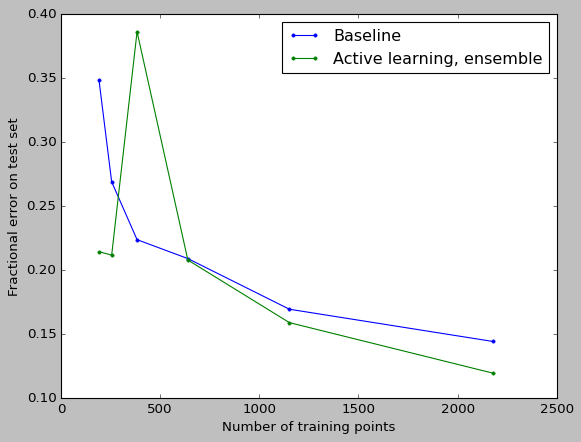

In [21]:
compare_err_plot(errors_baseline,errors_al)